## Aplicación y creación del Modelo de Machine Learning

**Target:**
- **`units_sold`**: número de unidades vendidas.

**Features**
- store_id: identificador único de la tienda.
- location: ubicación de la tienda (Madrid: 0, Barcelona: 1, Sevilla: 2, Valencia: 3, Itinerante: 4, Online: 5, Bilbao: 6).
- product_id: identificador único del producto.
- category: categoría del producto(Electrodomesticos: 0, Electronica: 1, Hogar: 2).
- product_price: precio del producto.
- product_cost: costo del producto.
- product_status: estado del producto (active: 0, paused: 1).
- sale_month: mes de la venta.
- sale_day: día del mes en que se realizó la venta.
- sale_weekday: día de la semana en que se realizó la venta.
- is_weekend: indicador de si la venta ocurrió en un fin de semana (1 = sí, 0 = no).
- days_since_opening: días transcurridos desde la apertura de la tienda hasta la venta.
- days_since_launch: días transcurridos desde el lanzamiento del producto hasta la venta.

### Librerías necesarias

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV,train_test_split

import pickle
import yaml

### DataFrame Final ML

In [3]:
# Leemos el DataFrame Final
df = pd.read_csv('..\\data\\df_final_ML.csv')

### Sacamos X e Y . Además, dividimos en train y test:

In [5]:
# Definimos x e y para el modelo
X = df.drop(columns=["units_sold"])
y = df["units_sold"]

In [6]:
# Dividimos en x_train, x_test, y_train, y_test para entrenar y evaluar el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print("Total features shape:", X.shape)
print("Train features shape:", X_train.shape)
print("Train target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Total features shape: (30, 13)
Train features shape: (24, 13)
Train target shape: (24,)
Test features shape: (6, 13)
Test target shape: (6,)


In [7]:
print("Distribución del Target en y:\n", y.value_counts(normalize=True))
print("-"*35)
print("Distribución del Target en y_train:\n", y_train.value_counts(normalize=True))
print("-"*35)
print("Distribución del Target en y_test:\n", y_test.value_counts(normalize=True))

Distribución del Target en y:
 units_sold
1    0.333333
2    0.333333
3    0.166667
5    0.133333
4    0.033333
Name: proportion, dtype: float64
-----------------------------------
Distribución del Target en y_train:
 units_sold
1    0.291667
2    0.291667
3    0.208333
5    0.166667
4    0.041667
Name: proportion, dtype: float64
-----------------------------------
Distribución del Target en y_test:
 units_sold
1    0.5
2    0.5
Name: proportion, dtype: float64


### Escalamos los datos
Escalar los datos equilibra la importancia de las características al ponerlas en el mismo rango, evitando que una con valores grandes domine el modelo. Así también, acelera la convergencia del entrenamiento y mejora la estabilidad numérica.

In [ ]:
# Escalamos los datos de X_train y X_test 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 
print("Train_caled features shape:", X_train_scaled.shape)
print("Test_scaled features shape:", X_test_scaled.shape)

Train features shape: (24, 13)
Test features shape: (6, 13)


### Modelos:
- Linear Regression  
- Random Forest      
- Gradient Boosting


### Hiperparametrizamos y entrenamos el modelo

GridSearch & Pipelines
- GridSearch es una herramienta de optimización que usamos cuando ajustamos hiperparámetros. Definimos la cuadrícula(grid) de parámetros que queremos buscar y seleccionamos la mejor combinación de parámetros para nuestros datos.

In [21]:
# Definimos el Pipeline base
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest(score_func=f_regression)),
    ("regressor", LinearRegression())
])

# Establecemos el espacio de búsqueda para GridSearchCV
linear_params = {
    'regressor': [LinearRegression()],
    'selectkbest__k': np.arange(5, 13),  # Número de características a seleccionar
}

random_forest_params = {
    'regressor': [RandomForestRegressor(random_state=10)],
    'selectkbest__k': np.arange(5, 13),
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__max_depth': [3, 5, 7]
}

gradient_boosting_params = {
    'regressor': [GradientBoostingRegressor(random_state=10)],
    'selectkbest__k': np.arange(5, 13),
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

search_space = [
    linear_params,
    random_forest_params,
    gradient_boosting_params
]


In [33]:
# Configuramos el GridSearchCV
reg_gs = GridSearchCV(
    estimator=pipe,
    param_grid=search_space,
    cv=10,  
    scoring="neg_mean_squared_error",  # métrica de evaluación
    verbose=3,
    n_jobs=-1  
)

# Entrenamiento
reg_gs.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 368 candidates, totalling 3680 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000239570C8E00>)),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'regressor': [LinearRegression()],
                          'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12])},
                         {'regressor': [RandomForestRegressor(random_state=10)],
                          're...
                          'regressor__max_features': ['sqrt', 'log2'],
                          'regressor__n_estimators': [50, 100, 200],
                          'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12])},
                         {'regressor': [GradientBoostingRegressor(random_state=10)],
                          'regressor__learning_rate': [0.01, 0.1, 0.2],
                          'regressor__max_depth': [3, 5, 7],
                          'regressor__n_estimators': [50, 100, 200],
                          'selectkbest__k': array([ 5,  6,  7,  8,  9, 10, 11, 12])}],
             scoring='neg_mean_squared_error', verbose=3)

- Resultados

In [62]:
# Mejores resultados
print("Mejor estimador:", reg_gs.best_estimator_)
print("Mejor puntaje (MSE negativo):", reg_gs.best_score_)  # Lo invertimos porque MSE es negativo
print("Mejores parámetros:", reg_gs.best_params_)

Mejor estimador: Pipeline(steps=[('scaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=12,
                             score_func=<function f_regression at 0x00000239570C8E00>)),
                ('regressor',
                 RandomForestRegressor(max_depth=3, max_features='sqrt',
                                       n_estimators=50, random_state=10))])
Mejor puntaje (MSE negativo): -2.601316813367344
Mejores parámetros: {'regressor': RandomForestRegressor(random_state=10), 'regressor__max_depth': 3, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 50, 'selectkbest__k': 12}


In [61]:
# Modelo final con mejores parámetros
final_model = reg_gs.best_estimator_
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)

# Métricas de evaluación para regresión
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 1.9486085658625418
Mean Absolute Error: 1.1572662985162985
R2 Score: -6.794434263450167


In [56]:
# Obtenemos el paso "selectkbest" del mejor pipeline
best_selectkbest = reg_gs.best_estimator_.named_steps['selectkbest']
# Obtenemos los nombres de las características seleccionadas
selected_features = X_train.columns[best_selectkbest.get_support()]

print("Características seleccionadas:", selected_features.tolist())

Características seleccionadas: ['store_id', 'location', 'product_id', 'category', 'product_price', 'product_cost', 'product_status', 'sale_month', 'sale_day', 'is_weekend', 'days_since_opening', 'days_since_launch']


In [64]:
# Obtenemos el mejor modelo (regresor) del pipeline ajustado
best_classifier = reg_gs.best_estimator_.named_steps['regressor']
# Extraemos las importancias de las características del modelo:
feature_importances = best_classifier.feature_importances_
feature_importances

array([0.08323827, 0.08194806, 0.10801047, 0.01946812, 0.04675109,
       0.098006  , 0.01053619, 0.11372264, 0.16830179, 0.01291786,
       0.15907176, 0.09802774])

In [63]:
# Creamos un DataFrame con las columnas "Feature" y "Importance":
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})
# Ordenamos las características por importancia en orden descendente para identificar cuáles tienen mayor influencia en las predicciones del modelo
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
8,sale_day,0.168302
10,days_since_opening,0.159072
7,sale_month,0.113723
2,product_id,0.108010
11,days_since_launch,0.098028
5,product_cost,0.098006
0,store_id,0.083238
1,location,0.081948
4,product_price,0.046751
3,category,0.019468


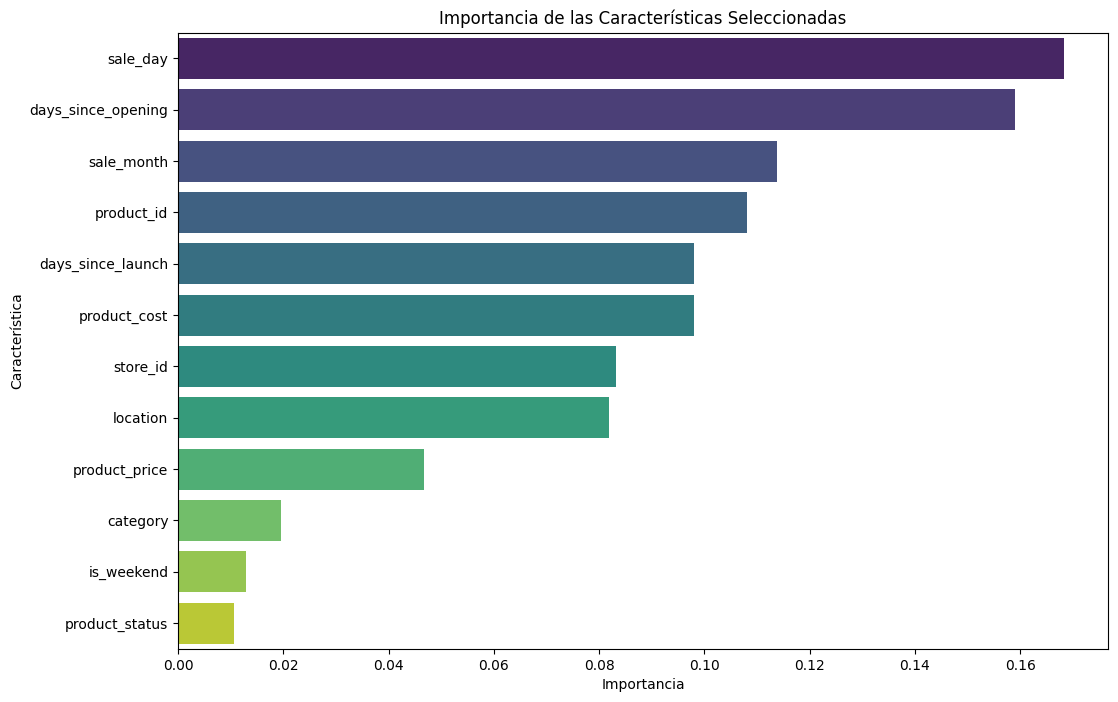

In [65]:
# Gráfico de barras de la importancia de las características seleccionadas
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importancia de las Características Seleccionadas')
plt.xlabel('Importancia')
plt.ylabel('Característica');

### Guardamos el modelo

In [68]:
# Guardamos el modelo final en un archivo .pkl
filename = '..\\models\\final_model_gs'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(final_model, archivo_salida)

In [69]:
# Guradamos la información del modelo en un archivo .yaml
model_info = {'regressor': RandomForestRegressor(random_state=10), 'regressor__max_depth': 3, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 50, 'selectkbest__k': 12}

with open('..\\models\\final_model_gs.yaml', 'w') as yaml_file:
    yaml.dump(model_info, yaml_file)

### Para importar el modelo

In [70]:
filename = '..\\models\\final_model_gs'
with open(filename, 'rb') as archivo_entrada:
    modelo_importado = pickle.load(archivo_entrada)

In [71]:
modelo_importado

Pipeline(steps=[('scaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=12,
                             score_func=<function f_regression at 0x00000239570C8E00>)),
                ('regressor',
                 RandomForestRegressor(max_depth=3, max_features='sqrt',
                                       n_estimators=50, random_state=10))])